# Hair Segmentation 

In [39]:
import os
import numpy as np
import torch
import torch.utils.data as td
from PIL import Image
import matplotlib.pyplot as plt
import math
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [40]:
# a = torch.rand(4,4)
# print(a.cuda())

## Import dataset

In [41]:
# Dataset class
class HairDataset(td.Dataset):
    
    #mode should be 'Training' or 'Testing'
    def __init__(self, img_dir, gt_dir, mode='Training', image_size=(128, 128)):
        super(HairDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.images_dir = os.path.join(img_dir, mode)
        self.images = sorted(os.listdir(self.images_dir))
        self.targets_dir = os.path.join(gt_dir, mode)
        self.targets = sorted(os.listdir(self.targets_dir))        
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])    
        img = np.asarray(Image.open(img_path).resize(self.image_size).convert('RGB'))/255
        target_path = os.path.join(self.targets_dir, self.targets[idx])    
        target = np.asarray(Image.open(target_path).resize(self.image_size).convert('RGB'))/255
        return img, target

Nombre d'images dans le training set : 840
Nombre d'images dans le testing set : 210


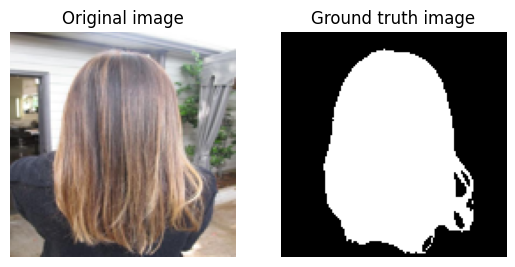

In [42]:
# define dataset dir path
img_dir = '/home/ndo001/Courses/project/hair-seg-project/Figaro1k/Original'
gt_dir = '/home/ndo001/Courses/project/hair-seg-project/Figaro1k/GT'

# build training and testing set
train_set =  HairDataset(img_dir=img_dir, gt_dir=gt_dir, mode='Training')
test_set =  HairDataset(img_dir=img_dir, gt_dir=gt_dir, mode='Testing')
print("Nombre d'images dans le training set :", len(train_set))
print("Nombre d'images dans le testing set :", len(test_set))

# Seperate orignals and ground truth
def image_mask_separator(set):
    X = []
    y = []
    for image, mask in train_set:
        X.append(image)
        y.append(mask[:,:,0])
    return np.array(X), np.array(y)

X_train, y_train = image_mask_separator(train_set)
X_test, y_test = image_mask_separator(test_set)

# visualize images
def visualize_data(images, axes):
    img, target = images[0], images[1]
    axes[0].imshow(img)
    axes[0].set_title('Original image')
    axes[0].axis('off')
    axes[1].imshow(target)
    axes[1].set_title('Ground truth image')
    axes[1].axis('off')

fig, axes = plt.subplots(ncols=2)
visualize_data(train_set[5], axes)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.48257852097816
[[[1.         1.         0.99215686]
  [1.         1.         0.99215686]
  [1.         1.         0.99215686]
  ...
  [0.98823529 0.98431373 0.96470588]
  [0.98823529 0.98431373 0.96470588]
  [0.99215686 0.98431373 0.96470588]]

 [[1.         1.         0.99215686]
  [1.         1.         0.99215686]
  [1.         1.         0.99215686]
  ...
  [0.98823529 0.98431373 0.96470588]
  [0.98823529 0.98431373 0.96470588]
  [0.99215686 0.98431373 0.96470588]]

 [[1.         1.         0.99215686]
  [1.         1.         0.99215686]
  [1.         1.         0.99215686]
  ...
  [0.98823529 0.98431373 0.96470588]
  [0.98823529 0.98431373 0.96470588]
  [0.99215686 0.98431373 0.96470588]]

 ...

 [[0.83921569 0.65882353 0.5254902 ]
  [0.83137255 0.65098039 0.51764706]
  [0.83921569 0.65882353 0.51764706]
  ...
  [0.78039216 0.60784314 0.47058824]
  [0.77647059 0.60392157 0.46666667]
  [0.76862745 0.59607843 0.45882353]]

 [[0.83921569 0.65882353 0.5254902 ]
  [0.83137255 0.6509

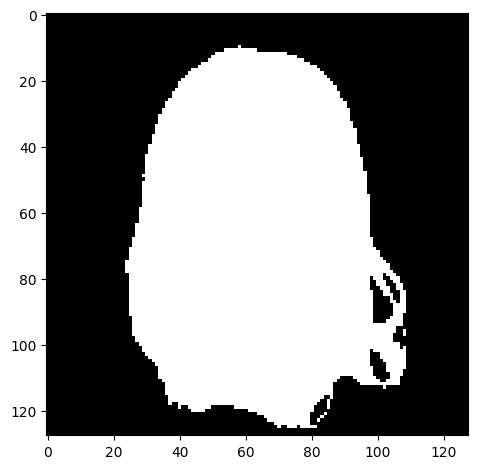

In [43]:
print(X_train.mean())
y = (y_train[5] * 255.)[:,:,np.newaxis]

index = np.where(X_train[0] != 0)[0]
print(X_train[0][index])

y = np.repeat(y, 3, axis=2)
print(y.shape)
plt.imshow(y)
plt.tight_layout()

## Create CNN

In [44]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.losses import BinaryCrossentropy


In [45]:
# Architecture from https://www.kaggle.com/code/rahuldshetty/hair-segmentation-using-u-net/notebook
inputs = Input((128, 128, 3))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
poo5a = MaxPooling2D(pool_size=(2, 2))(conv5)
conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(poo5a)
conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5a)

In [46]:
up6a = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5a), conv5], axis=3)
conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(up6a)
conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6a)
up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
conv10 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer='adam', loss='mse', metrics=['acc'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_114 (Conv2D)            (None, 128, 128, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_115 (Conv2D)            (None, 128, 128, 32  9248        ['conv2d_114[0][0]']             
                                )                                                           

In [47]:
epochs = 10
if os.path.isfile('./model.h5'):
    model = load_model('model.h5')
else:
    history = model.fit(X_train,y_train,validation_split=0.05,epochs=epochs,batch_size=64,)
    model.save('model.h5')

Epoch 1/10
13/13 [==============================] - 72s 5s/step - loss: 0.3054 - acc: 0.6269 - val_loss: 0.2106 - val_acc: 0.7498
Epoch 2/10
13/13 [==============================] - 71s 5s/step - loss: 0.2626 - acc: 0.6458 - val_loss: 0.1972 - val_acc: 0.7497
Epoch 3/10
13/13 [==============================] - 72s 5s/step - loss: 0.2336 - acc: 0.6504 - val_loss: 0.1938 - val_acc: 0.7331
Epoch 4/10
13/13 [==============================] - 70s 5s/step - loss: 0.2129 - acc: 0.6466 - val_loss: 0.1813 - val_acc: 0.7492
Epoch 5/10
13/13 [==============================] - 70s 5s/step - loss: 0.2076 - acc: 0.6634 - val_loss: 0.1816 - val_acc: 0.7332
Epoch 6/10
13/13 [==============================] - 70s 5s/step - loss: 0.2601 - acc: 0.6588 - val_loss: 0.1931 - val_acc: 0.7498
Epoch 7/10
13/13 [==============================] - 69s 5s/step - loss: 0.2332 - acc: 0.6532 - val_loss: 0.1849 - val_acc: 0.7467
Epoch 8/10
13/13 [==============================] - 72s 6s/step - loss: 0.2042 - acc: 0.65

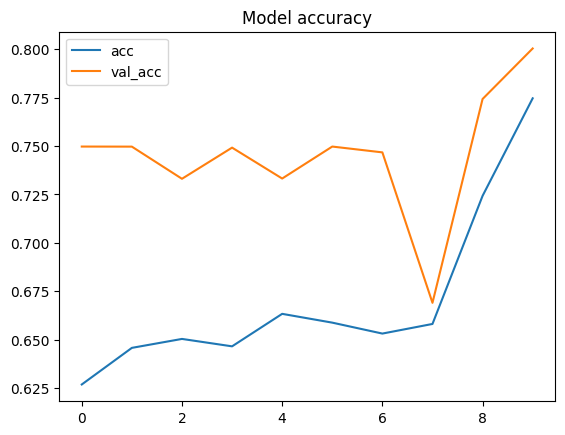

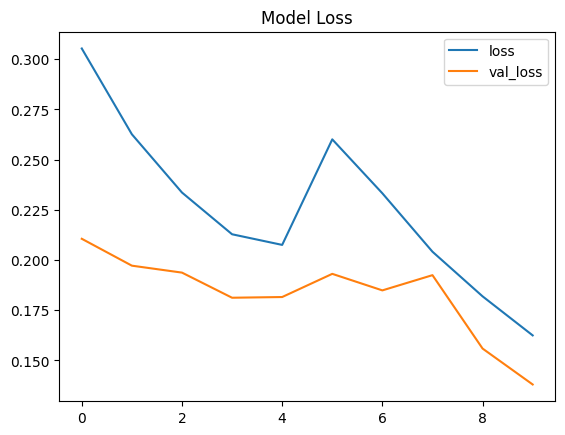

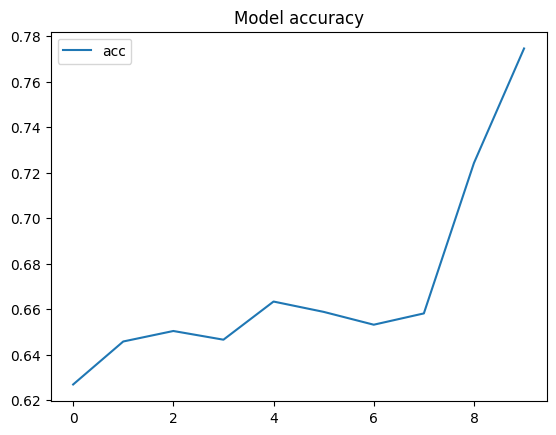

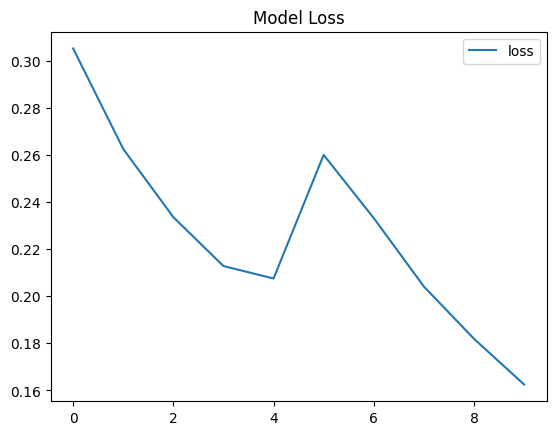

In [52]:
h = history
plt.plot(h.history['acc'], label='acc')
plt.plot(h.history['val_acc'], label='val_acc')
plt.title('Model accuracy')
plt.legend()
plt.show()

plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.legend()
plt.show()

plt.plot(h.history['acc'], label='acc')
plt.title('Model accuracy')
plt.legend()
plt.show()

plt.plot(h.history['loss'], label='loss')
plt.legend()
plt.title('Model Loss')
plt.show()

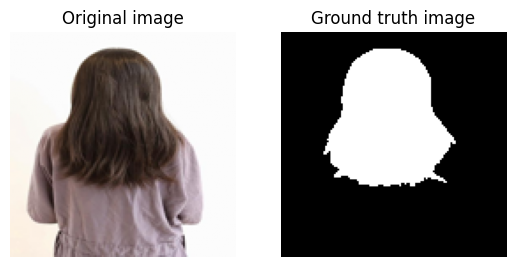

In [74]:
idx = 10
fig, axes = plt.subplots(ncols=2)
visualize_data(train_set[idx], axes)

In [75]:
def predict(image):
    return model.predict(image)

pred = predict(X_train)


27/27 [==============================] - 11s 424ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(840, 128, 128, 1)


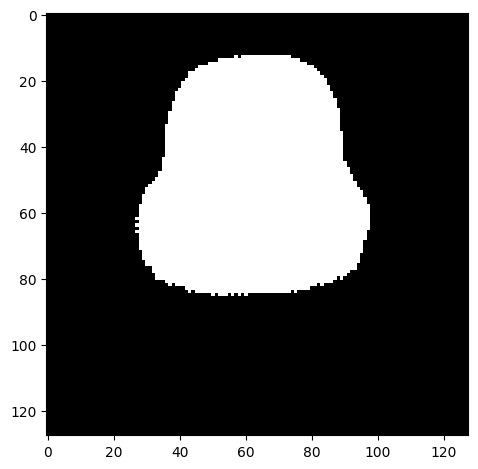

In [73]:
treshold = 0.5
print(pred.shape)

#Get predicted masks
pred_mask = ((pred > treshold) * 255.)
pred_mask = np.repeat(pred_mask, 3, axis=3)

plt.imshow(pred_mask[idx])
plt.tight_layout()